In [133]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

In [134]:
movie_md=pd.read_csv('data/movies_metadata.csv',low_memory=False)
movie_keywords=pd.read_csv('data/keywords.csv',low_memory=False)
movie_credits=pd.read_csv('data/credits.csv',low_memory=False)
print(movie_md.shape)

(45466, 24)


In [135]:
movie_md = movie_md[movie_md['vote_count']>=55]
movie_md = movie_md[['id','original_title','overview','genres']]
movie_md['title'] = movie_md['original_title'].copy()
movie_md.reset_index(inplace=True, drop=True)
movie_credits = movie_credits[['id','cast']]

In [136]:
movie_credits.head()

,id,cast
0,862,"[{'cast_id': 14, 'character': 'Woody (voice)',..."
1,8844,"[{'cast_id': 1, 'character': 'Alan Parrish', '..."
2,15602,"[{'cast_id': 2, 'character': 'Max Goldman', 'c..."
3,31357,"[{'cast_id': 1, 'character': ""Savannah 'Vannah..."
4,11862,"[{'cast_id': 1, 'character': 'George Banks', '..."


In [85]:
movie_md.head()

,id,original_title,overview,genres,title
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men
3,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II
4,949,Heat,"Obsessive master thief, Neil McCauley leads a ...","[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat


## Data Cleaning & Preprocessing
## movie_md = movie_md[movie_md['id'].str.isnumeric()]

In [86]:

movie_md['id'] = movie_md['id'].astype(int)

df = pd.merge(movie_md, movie_keywords, on='id', how='left')

df.reset_index(inplace=True, drop=True)

df = pd.merge(df, movie_credits, on='id', how='left')

df.reset_index(inplace=True, drop=True)

df.head()

,id,original_title,overview,genres,title,keywords,cast
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',..."
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '..."
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c..."
3,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '..."
4,949,Heat,"Obsessive master thief, Neil McCauley leads a ...","[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat,"[{'id': 642, 'name': 'robbery'}, {'id': 703, '...","[{'cast_id': 25, 'character': 'Lt. Vincent Han..."


In [87]:
df['genres'] = df['genres'].apply(lambda x: [i['name'] for i in eval(x)])

df['genres'] = df['genres'].apply(lambda x: ' '.join([i.replace(" ","") for i in x]))
#Filling the nan values as []
df['keywords'].fillna('[]', inplace=True)

df['keywords'] = df['keywords'].apply(lambda x: [i['name'] for i in eval(x)])

df['keywords'] = df['keywords'].apply(lambda x: ' '.join([i.replace(" ",'') for i in x]))

#Filling the nan values as []

df['cast'].fillna('[]', inplace=True)

df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in eval(x)])

df['cast'] = df['cast'].apply(lambda x: ' '.join([i.replace(" ",'') for i in x]))
df.head()

,id,original_title,overview,genres,title,keywords,cast
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",Animation Comedy Family,Toy Story,jealousy toy boy friendship friends rivalry bo...,TomHanks TimAllen DonRickles JimVarney Wallace...
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,Adventure Fantasy Family,Jumanji,boardgame disappearance basedonchildren'sbook ...,RobinWilliams JonathanHyde KirstenDunst Bradle...
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,Romance Comedy,Grumpier Old Men,fishing bestfriend duringcreditsstinger oldmen,WalterMatthau JackLemmon Ann-Margret SophiaLor...
3,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,Comedy,Father of the Bride Part II,baby midlifecrisis confidence aging daughter m...,SteveMartin DianeKeaton MartinShort KimberlyWi...
4,949,Heat,"Obsessive master thief, Neil McCauley leads a ...",Action Crime Drama Thriller,Heat,robbery detective bank obsession chase shootin...,AlPacino RobertDeNiro ValKilmer JonVoight TomS...


In [88]:
fig = px.bar(df, x='genres', y='title')
fig.show()

# fig = px.pie(df, names='genres', color_discrete_sequence=px.colors.sequential.RdBu)
# fig.show()

## merge all content/description of movies as a single feature

In [89]:
df['tags'] = df['overview'] + ' ' + df['genres'] +  ' ' + df['original_title'] + ' ' + df['keywords'] + ' ' + df['cast']

# Delete useless columns
df.drop(columns=['genres','overview','original_title','keywords','cast'], inplace=True)
df.head()

,id,title,tags
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,8844,Jumanji,When siblings Judy and Peter discover an encha...
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...
4,949,Heat,"Obsessive master thief, Neil McCauley leads a ..."


In [90]:
df.isnull().sum()

df.drop(df[df['tags'].isnull()].index, inplace=True)
df.drop_duplicates(inplace=True)

In [91]:
tfidf = TfidfVectorizer(max_features=5000)
vectorized_data = tfidf.fit_transform(df['tags'].values)
vectorized_dataframe = pd.DataFrame(vectorized_data.toarray(), index=df['tags'].index.tolist())

#Perform Dimension Reduction¶
svd = TruncatedSVD(n_components=3000)

# Fit transform the data
reduced_data = svd.fit_transform(vectorized_dataframe)

# Print the shape
print(reduced_data.shape)


#Compute a similarity metric on vectors for recommendation
similarity = cosine_similarity(reduced_data)

(8595, 3000)


In [96]:
# Making recommendations for a given movie
def recommendation(movie_title):
    id_of_movie = df[df['title'] == movie_title].index[0]
    distances = similarity[id_of_movie]
    movie_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:10]

    for i in movie_list:
        print(df.iloc[i[0]].title)

print(recommendation('The Shawshank Redemption'))

Brubaker
杀破狼2
In Hell
A Christmas Story
Un prophète
Dark Passage
The Samaritan
Lock Up
Rosewater
None


In [160]:
#Most Popular Movies
#pop=df.sort_values('title', ascending=False)
#plt.figure(figsize=(12,4))
#plt.barh(pop['title_x'].head(6),pop['title'].head(6),align='center',
#        color='m')
#plt.gca().inver_yaxis()
#plt.xlabel('Popularity')
#plt.title('Popular Movies')

In [97]:
tsne = TSNE(n_components=2)

# Fir transform the data
tsne_data = tsne.fit_transform(vectorized_data)

# Convert to dataframe
tsne_data = pd.DataFrame(tsne_data, columns=['x','y'])

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [94]:
tsne_data['title'] = df['title'].copy()

In [100]:
#df = go.Scatter(x=tsne_data['x'],y=tsne_data['y'],text=tsne_data['title'],mode='markers+text',)
#fig = go.Figure(df=df)
#fig.show()

In [78]:

fig = px.pie(df, names='title', color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

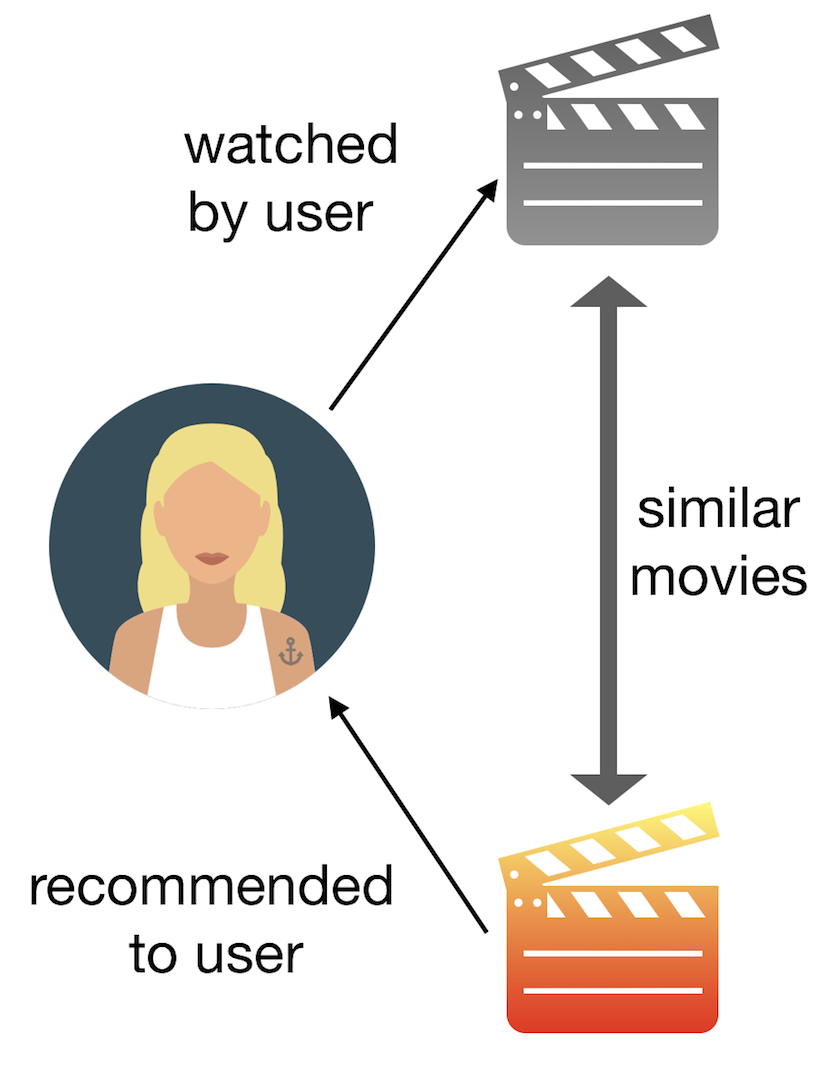

In [79]:
from IPython.display import Image
Image(filename='diagrams/item-based.png')

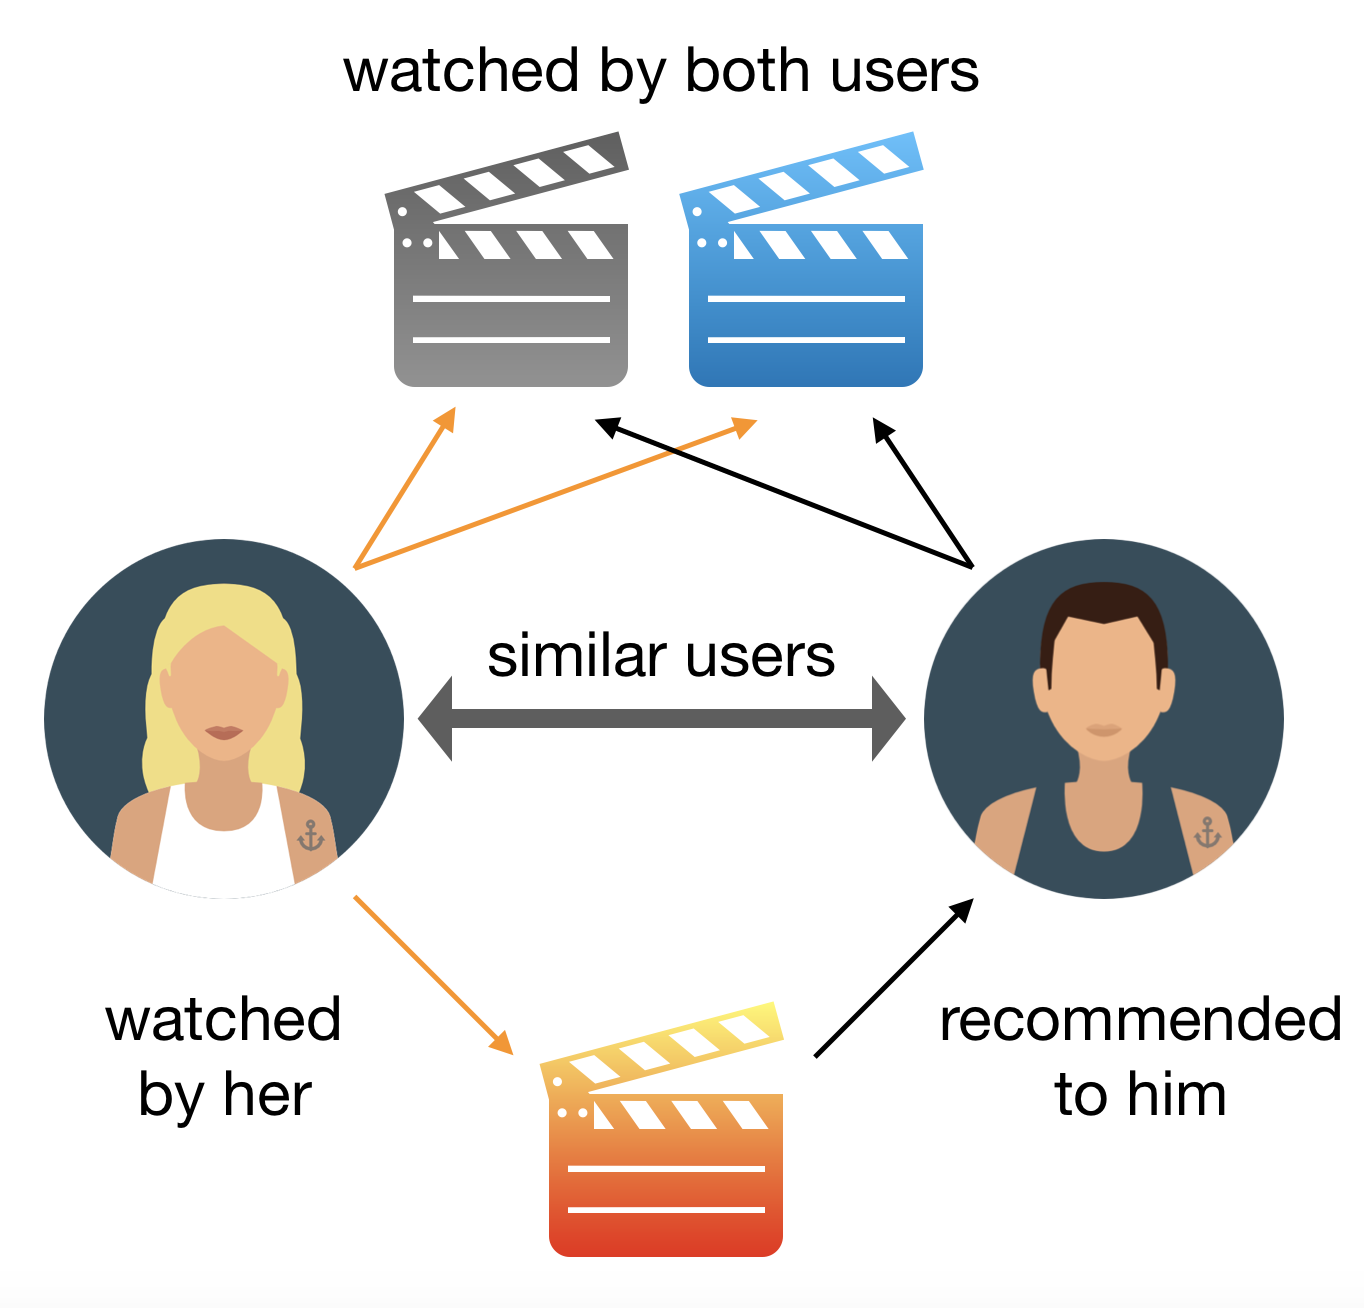

In [80]:
Image(filename='diagrams/user-based.png')

In [148]:
#We will merge the movies and credits dataframes and select the columns which are required and have a unified movies dataframe to work on.
movie_md['genres'] = movie_md['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movie_md['genres'] = movie_md['genres'].str.split(',')

In [149]:
#check the movie_md.columns columns
movie_md.columns

Index(['id', 'original_title', 'overview', 'genres', 'title'], dtype='object')

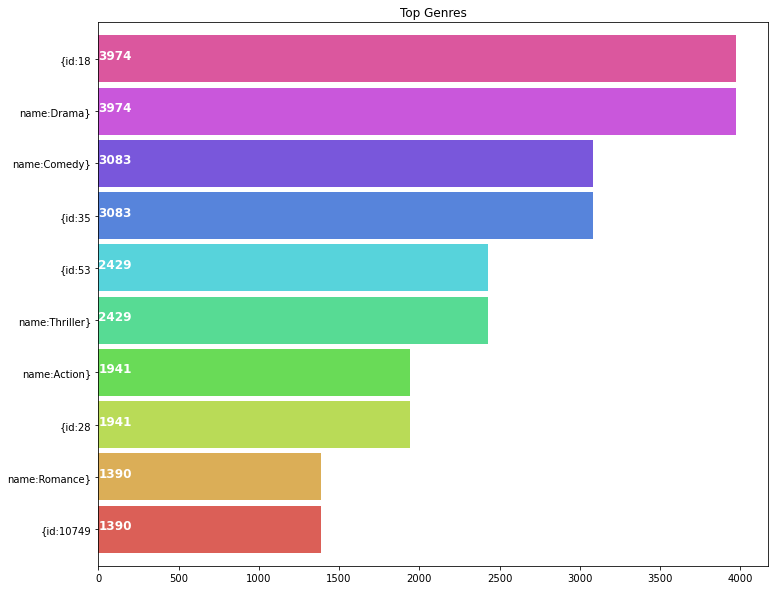

In [150]:
plt.subplots(figsize=(12,10))
list1 = []
for i in movie_md['genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()

Drama appears to be the most popular genre followed by Comedy

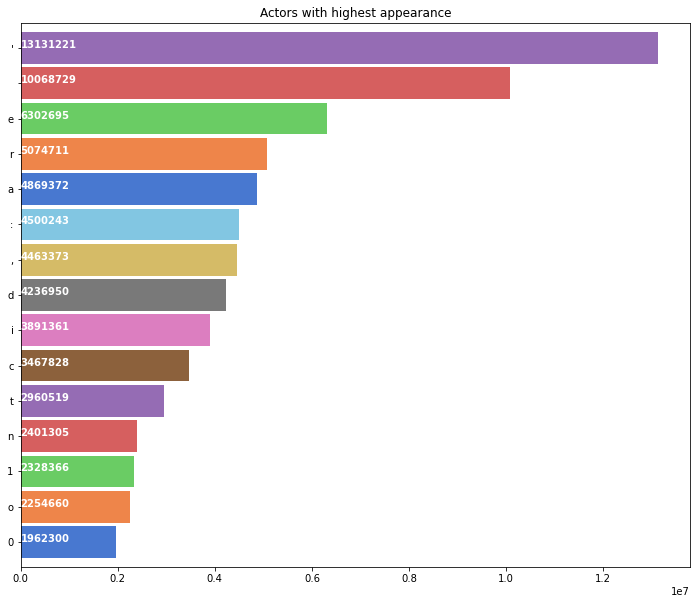

In [153]:
plt.subplots(figsize=(12,10))
list1=[]
for i in movie_credits['cast']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(pd.Series(list1).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')
plt.title('Actors with highest appearance')
plt.show()

In [144]:
movie_md.columns

Index(['id', 'original_title', 'overview', 'genres', 'title'], dtype='object')